In [1]:
# installing segmentation-models-pytorch library which will be used to build the model
!pip install segmentation-models-pytorch -q

In [2]:
# All the module imports in this section

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import glob
import torch
import torch.nn as nn
import torch.utils as utils
import torch.nn.init as init
import torch.utils.data as data
import torchvision.utils as v_utils
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.autograd import Variable
import numpy as np
from random import shuffle
import scipy.misc
from PIL import Image
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn
import cv2
import os
import glob

In [3]:
#list of 14 cities for which images are available in the dataset

cities = ['paris',
 'rennes',
 'bercy',
 'abudhabi',
 'hongkong',
 'aguasclaras',
 'saclay_e',
 'beirut',
 'mumbai',
 'pisa',
 'beihai',
 'bordeaux',
 'cupertino',
 'nantes']

In [4]:
len(cities) # checking the lenght of the list

14

In [5]:
# specifying input path to read images
input_path = "../input/onera-satellite-change-detection-dataset/images/Onera Satellite Change Detection dataset - Images/"

img1 = []   # creating list of imagery paths for first set of images 
img2 = []   # creating list of imagery paths for second set of images
label = []  # creating list of change mask paths for the images

for city in cities:
    img1.append(input_path + city + "/pair/" + "img1.png")
    img2.append(input_path + city + "/pair/" + "img2.png")
    label.append(f"../input/onera-satellite-change-detection-dataset/train_labels/Onera Satellite Change Detection dataset - Train Labels/{city}/cm/cm.png")


5
(471, 525, 2)


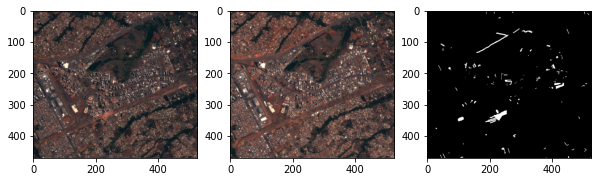

In [6]:
# read a random sample - two set of images and the associated change mask

from PIL import Image
import matplotlib.pyplot as plt

sample = np.random.randint(0,13) # generate a random number    
print(sample)
im1 = Image.open(img1[sample])
im2 = Image.open(img2[sample])
lab = Image.open(label[sample]).convert('LA')
print(np.array(lab).shape)
fig,ax = plt.subplots(1,3,figsize=(10,10))
ax[0].imshow(im1)
ax[1].imshow(im2)
ax[2].imshow(lab)

In [7]:
# Below code to divide the whole images into patches of 64X64 

path1 = []
path2 = []
target = []
start_row = []
end_row = []
start_col = []
end_col = []

for im1,im2,lab in zip(img1,img2,label):
    for row in [0,64,128,192,256,320,384,448]:
        for col in [0,64,128,192,256,320,384,448]:
            row_start = row
            row_end = row + 64
            col_start = col
            col_end = col + 64
            
            path1.append(im1)
            path2.append(im2)
            target.append(lab)
            
            start_row.append(row_start)
            end_row.append(row_end)
            
            start_col.append(col_start)
            end_col.append(col_end)
            
df = pd.DataFrame({"path1":path1,"path2":path2,"target":target,"start_row":start_row,"end_row":end_row,"start_col":start_col,"end_col":end_col})
df

,path1,path2,target,start_row,end_row,start_col,end_col
0,../input/onera-satellite-change-detection-data...,../input/onera-satellite-change-detection-data...,../input/onera-satellite-change-detection-data...,0,64,0,64
1,../input/onera-satellite-change-detection-data...,../input/onera-satellite-change-detection-data...,../input/onera-satellite-change-detection-data...,0,64,64,128
2,../input/onera-satellite-change-detection-data...,../input/onera-satellite-change-detection-data...,../input/onera-satellite-change-detection-data...,0,64,128,192
3,../input/onera-satellite-change-detection-data...,../input/onera-satellite-change-detection-data...,../input/onera-satellite-change-detection-data...,0,64,192,256
4,../input/onera-satellite-change-detection-data...,../input/onera-satellite-change-detection-data...,../input/onera-satellite-change-detection-data...,0,64,256,320
...,...,...,...,...,...,...,...
891,../input/onera-satellite-change-detection-data...,../input/onera-satellite-change-detection-data...,../input/onera-satellite-change-detection-data...,448,512,192,256
892,../input/onera-satellite-change-detection-data...,../input/onera-satellite-change-detection-data...,../input/onera-satellite-change-detection-data...,448,512,256,320
893,../input/onera-satellite-change-detection-data...,../input/onera-satellite-change-detection-data...,../input/onera-satellite-change-detection-data...,448,512,320,384
894,../input/onera-satellite-change-detection-data...,../input/onera-satellite-change-detection-data...,../input/onera-satellite-change-detection-data...,448,512,384,448


In [8]:
#Python dataset class to be used for generating images and labels for training the model

class ChangeDataset():
    def __init__(self,df):
        self.df = df
        
    def __len__(self):
        return (len(self.df))
    
    def __getitem__(self,item):
        im1 = Image.open(self.df.loc[item,"path1"])
        im1 = np.array(im1.resize((512,512))) / 255 # resizing the image to 512X512
        im2 = Image.open(self.df.loc[item,"path2"])
        im2 = np.array(im2.resize((512,512))) / 255 # resizing the image to 512X512
        target = Image.open(self.df.loc[item,"target"]).convert("RGB")
        target = np.array(target.resize((512,512))) # resizing the mask to 512X512
        target = (np.mean(target,axis=-1) > 0.5).astype(np.uint8)
        start_row = self.df.loc[item,"start_row"]
        end_row = self.df.loc[item,"end_row"]
        start_col = self.df.loc[item,"start_col"]
        end_col = self.df.loc[item,"end_col"]
        
        # read a 64X64 patch from the base image1
        im1 = torch.tensor(im1[start_row:end_row,start_col:end_col,:].transpose(2,1,0),dtype=torch.float)
          # read a 64X64 patch from the base image2
        im2 = torch.tensor(im2[start_row:end_row,start_col:end_col,:].transpose(2,1,0),dtype=torch.float)
          # read a 64X64 patch from the base change mask
        target = torch.tensor(target[start_row:end_row,start_col:end_col],dtype=torch.long)
        
        return (im1,im2,target)

In [9]:
train_ds = ChangeDataset(df[:700])  # train dataset
val_ds = ChangeDataset(df[700:].reset_index(drop=True)) # validation dataset

sample = np.random.randint(0,100) # generate a random number

im1,im2,target = train_ds[sample] # read a random sample 
print(train_ds[sample])
im1.shape,im2.shape,target.shape  # check shape

(tensor([[[0.2118, 0.2039, 0.2039,  ..., 0.1412, 0.1647, 0.1725],
         [0.2275, 0.2157, 0.2510,  ..., 0.1490, 0.1608, 0.1725],
         [0.2353, 0.1765, 0.2314,  ..., 0.1569, 0.1608, 0.1725],
         ...,
         [0.0745, 0.0784, 0.0824,  ..., 0.0863, 0.0941, 0.1333],
         [0.0745, 0.0784, 0.0824,  ..., 0.0980, 0.1176, 0.1804],
         [0.0863, 0.0863, 0.0863,  ..., 0.1333, 0.1882, 0.2667]],

        [[0.2471, 0.2431, 0.2392,  ..., 0.1882, 0.2078, 0.2157],
         [0.2627, 0.2510, 0.2706,  ..., 0.1961, 0.2039, 0.2157],
         [0.2706, 0.2235, 0.2588,  ..., 0.2039, 0.2000, 0.2118],
         ...,
         [0.1451, 0.1608, 0.1686,  ..., 0.1686, 0.1647, 0.1843],
         [0.1451, 0.1608, 0.1686,  ..., 0.1765, 0.1804, 0.2157],
         [0.1490, 0.1569, 0.1647,  ..., 0.2000, 0.2431, 0.2980]],

        [[0.3294, 0.3373, 0.3451,  ..., 0.3059, 0.3137, 0.3059],
         [0.3490, 0.3412, 0.3686,  ..., 0.3020, 0.3020, 0.3059],
         [0.3725, 0.3255, 0.3569,  ..., 0.3059, 0.3098, 0

(torch.Size([3, 64, 64]), torch.Size([3, 64, 64]), torch.Size([64, 64]))

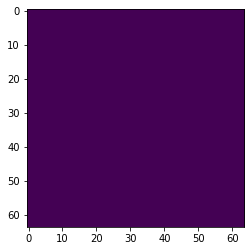

In [10]:
plt.imshow(target.numpy())  # plot the change mask

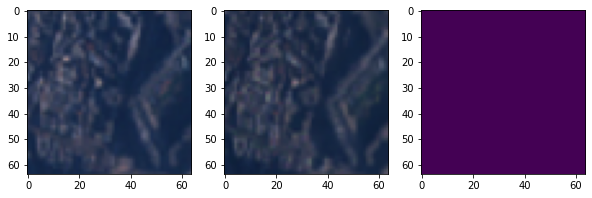

In [11]:
# plot the image1, image2 and the change mask

fig,ax = plt.subplots(1,3,figsize=(10,10))
ax[0].imshow(im1.numpy().transpose(1,2,0))
ax[1].imshow(im2.numpy().transpose(1,2,0))
ax[2].imshow(target.numpy())

In [12]:
from torch.utils.data import DataLoader
train_dl = DataLoader(train_ds,batch_size=256, shuffle=True)  # train dataset to train dataloader
val_dl = DataLoader(val_ds,batch_size=256, shuffle=False)  # valid dataset to valid dataloader

In [13]:
model = smp.Unet('resnet34', encoder_depth=3,decoder_channels=(64, 64, 16)) # build a base model based on Unet architecture with a resnet34 encoder 

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [14]:
# ChangeNet model

class ChangeNet(nn.Module):
    def __init__(self,model):
        super().__init__()
        self.encoder = model.encoder  #model encoder
        self.decoder = model.decoder  #model decoder
        self.head = model.segmentation_head  #segmentation head for generation of change mask
        
    def forward(self,x1,x2):
        enc1 = self.encoder(x1)  # get latent features of image1
        enc2 = self.encoder(x2)  # get latent features of image2
        encoder_out = []
        for i in range(len(enc1)):
            encoder_out.append(torch.add(enc1[i],enc2[i])) # Add the latent features and append them to a list
        decoder_out = self.decoder(*encoder_out) # Pass the latent features through a decoder
        out = self.head(decoder_out) # Pass the decoder output through the segmentation head to generate change mask
        return out

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else'cpu')  #Training on gpu if available

In [16]:
change_model = ChangeNet(model).to(device) #migrating model to device

In [17]:
from tqdm.notebook import tqdm

criterion = torch.nn.BCEWithLogitsLoss().to(device)   #loss function is BCE loss since it is binary classification
optimizer = torch.optim.Adam(change_model.parameters(), lr=0.0001)

for epoch in tqdm(range(5)):  # Number of epochs = 5
    
    epoch_loss = []
    # Iterate over data.
        
    change_model.train() # setting model state to train
    for x1,x2,target in tqdm(train_dl,total=len(train_dl)):
        x1 = x1.to(device)  #migrating inputs to device
        x2 = x2.to(device)  #migrating inputs to device
        target = target.to(device)  #migrating inputs to device
                
        # zero the parameter gradients
        optimizer.zero_grad()   #resetting the optimizer

        # forward
        outputs = change_model(x1,x2)  # generating model predictions
        loss = criterion(outputs.squeeze(), target.float()) # evaluating loss

        # backward + optimize only if in training phase
        
        loss.backward()  # calculating gradients
        optimizer.step()  # using optimizer to recalculate parameters
        epoch_loss.append(loss.item())
    
    print(f"Epoch {epoch}, Loss:",np.array(epoch_loss).mean())

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 0, Loss: 0.7498238881429037


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1, Loss: 0.7234499057133993


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 2, Loss: 0.6985463897387186


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 3, Loss: 0.6738110582033793


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 4, Loss: 0.6495164036750793


In [18]:
len(val_ds)

196

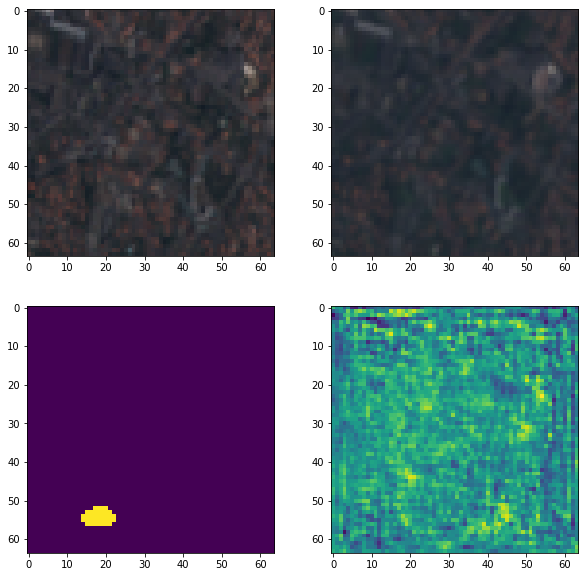

In [19]:
change_model.eval()  #setting model to eval for generating predictions

s = 190 # sample - random

with torch.no_grad():
    #generating prediction & passing the prediction through torch.sigmoid 
    pred_mask = (torch.sigmoid(change_model(val_ds[s][0].unsqueeze(dim=0).to(device),val_ds[s][1].unsqueeze(dim=0).to(device))).squeeze()).detach().cpu().numpy()  


# displaying sample image1, sample image2, sample ground truth mask, and predicted mask    
fig,ax = plt.subplots(2,2,figsize=(10,10))
ax[0][0].imshow(val_ds[s][0].numpy().transpose(1,2,0))
ax[0][1].imshow(val_ds[s][1].numpy().transpose(1,2,0))
ax[1][0].imshow(val_ds[s][2].numpy())
ax[1][1].imshow(pred_mask)
